In [5]:
from copy import deepcopy

import numpy as np
import pandas as pd
from scipy.cluster import hierarchy as sch

from matplotlib import pyplot as plt

import scanpy as sc
import squidpy as sq

%matplotlib inline

In [25]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import linalg
EPSILON = 1.1920929e-07
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import scanpy as sc
import pandas as pd
import spatialdm as sdm
import squidpy as sq
import tqdm
import adjustText
from scipy.optimize import minimize, minimize_scalar
from sklearn.neighbors import NearestNeighbors
import importlib

In [27]:
import sys
sys.path.append("/Users/hs0424/Workspace/copulacci/src/copulacci/")
import cci
import spatial
import model
import simulation

/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
import warnings
import networkx as nx

# Silencing FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [7]:
adata = sq.datasets.seqfish()

/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


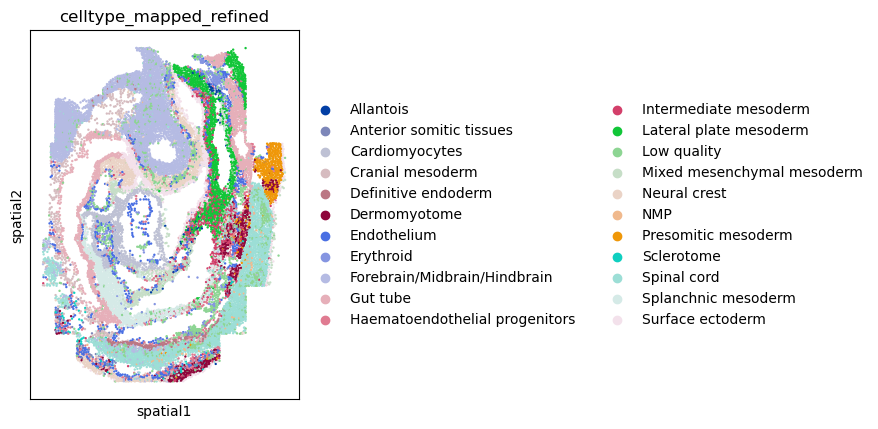

In [17]:
sc.pl.spatial(
    adata, color="celltype_mapped_refined",
    spot_size=0.05
)

In [22]:
adata.obs['celltype'] = adata.obs.celltype_mapped_refined

In [23]:
adata

AnnData object with n_obs × n_vars = 19416 × 351
    obs: 'Area', 'celltype_mapped_refined', 'celltype'
    uns: 'celltype_mapped_refined_colors'
    obsm: 'X_umap', 'spatial'

In [28]:
sdm.extract_lr(adata, 'mouse', min_cell=20)

In [33]:
from scipy.spatial.distance import pdist, squareform

In [34]:
distances = pdist(adata.obsm['spatial'])

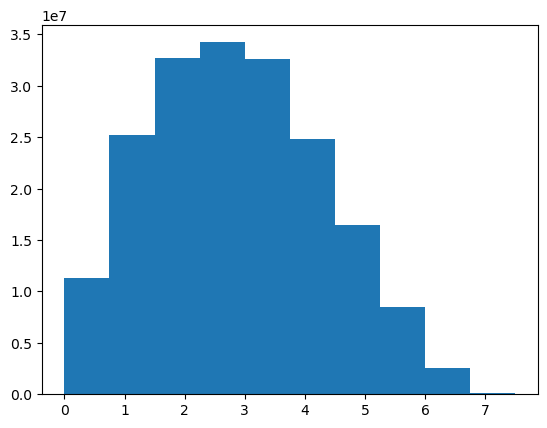

In [38]:
plt.hist(distances);

In [39]:
importlib.reload(spatial)

<module 'spatial' from '/Users/hs0424/Workspace/copulacci/src/copulacci/spatial.py'>

In [45]:
spatial.construct_spatial_network(adata, data_type='stereo', radius=0.1)

In [46]:
print(adata.uns['spatial_network'])

Graph with 19416 nodes and 296717 edges


In [47]:
296717 / 19416

15.282086938607334

In [48]:
int_edges_new, int_edges_with_selfloop = spatial.construct_boundary(
    adata
)

relabeling nodes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19416/19416 [00:01<00:00, 10731.06it/s]


In [49]:
int_edges_with_selfloop.boundary_type.value_counts()

boundary_type
External    236756
Internal     37050
Name: count, dtype: int64

In [61]:
external_edges = int_edges_new.loc[
int_edges_new.boundary_type == 'External'
].interaction.unique()

In [62]:
int_edges_new.boundary_type.value_counts()

boundary_type
External    236756
Internal     17634
Name: count, dtype: int64

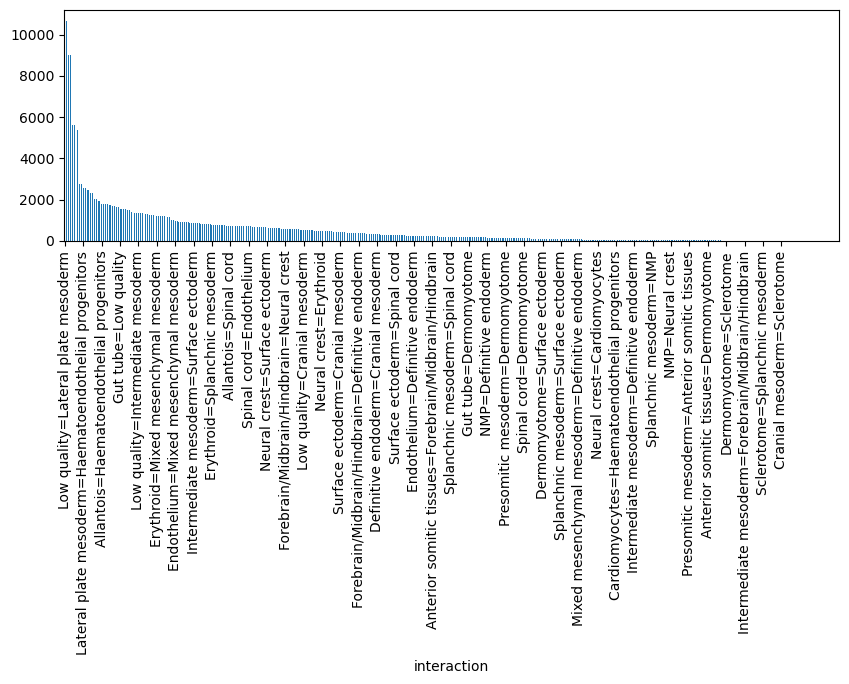

In [63]:
fig, ax = plt.subplots(1,1, figsize=(10,3))
int_edges_new.loc[
int_edges_new.boundary_type == 'External'
].interaction.value_counts().plot(kind='bar',ax =ax)

x_tick_positions = list(range(0,400,10))
x_tick_labels = external_edges[x_tick_positions] 
ax.set_xticks(x_tick_positions);
ax.set_xticklabels(x_tick_labels);

In [103]:
int_edges_new = int_edges_new.loc[(
    (int_edges_new.celltype1 != 'Low quality') &
    (int_edges_new.celltype2 != 'Low quality'))
]

In [105]:
external_edges = int_edges_new.loc[
int_edges_new.boundary_type == 'External'
].interaction.unique()

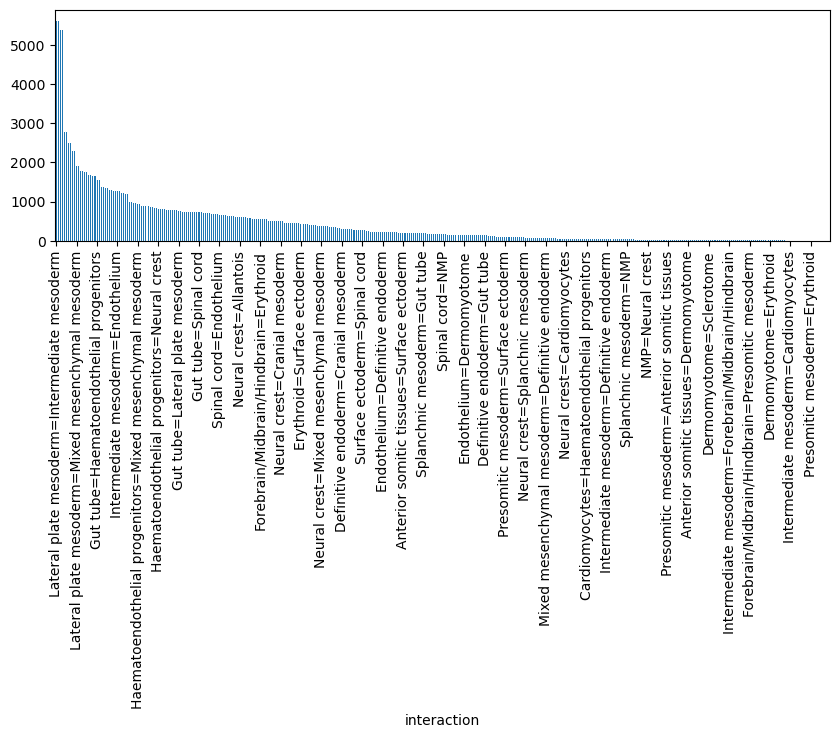

In [108]:
fig, ax = plt.subplots(1,1, figsize=(10,3))
int_edges_new.loc[
int_edges_new.boundary_type == 'External'
].interaction.value_counts().plot(kind='bar',ax =ax)

x_tick_positions = list(range(0,380,10))
x_tick_labels = external_edges[x_tick_positions] 
ax.set_xticks(x_tick_positions);
ax.set_xticklabels(x_tick_labels);

In [71]:
boundary_type_subsets = int_edges_new.interaction.value_counts()[
    (int_edges_new.interaction.value_counts() > 1500)
].index

In [72]:
len(boundary_type_subsets)

37

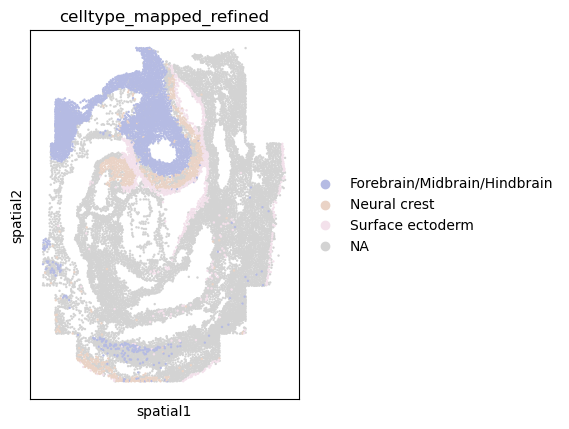

In [91]:
sc.pl.spatial(
    adata, color="celltype_mapped_refined",
    groups = ['Forebrain/Midbrain/Hindbrain','Neural crest','Surface ectoderm'],
    spot_size=0.05
)

In [85]:
sorted(boundary_type_subsets)

['Cardiomyocytes=Cardiomyocytes',
 'Dermomyotome=Intermediate mesoderm',
 'Endothelium=Gut tube',
 'Endothelium=Haematoendothelial progenitors',
 'Endothelium=Lateral plate mesoderm',
 'Endothelium=Low quality',
 'Endothelium=Neural crest',
 'Erythroid=Low quality',
 'Forebrain/Midbrain/Hindbrain=Forebrain/Midbrain/Hindbrain',
 'Forebrain/Midbrain/Hindbrain=Low quality',
 'Forebrain/Midbrain/Hindbrain=Spinal cord',
 'Gut tube=Endothelium',
 'Gut tube=Splanchnic mesoderm',
 'Haematoendothelial progenitors=Endothelium',
 'Haematoendothelial progenitors=Lateral plate mesoderm',
 'Intermediate mesoderm=Dermomyotome',
 'Intermediate mesoderm=Lateral plate mesoderm',
 'Lateral plate mesoderm=Endothelium',
 'Lateral plate mesoderm=Haematoendothelial progenitors',
 'Lateral plate mesoderm=Intermediate mesoderm',
 'Low quality=Endothelium',
 'Low quality=Erythroid',
 'Low quality=Forebrain/Midbrain/Hindbrain',
 'Low quality=Neural crest',
 'Low quality=Spinal cord',
 'Low quality=Splanchnic mes

In [73]:
int_edges_subset = int_edges_new.loc[
    int_edges_new.interaction.isin(boundary_type_subsets)
]

In [75]:
df_lig_rec_linear = cci.extract_lig_rec_from_sdm(adata, allow_same_lr=True)
chosen_lr = list(set( df_lig_rec_linear.ligand.unique()).union(
    set( df_lig_rec_linear.receptor.unique() )
))
count_df = adata.raw.to_adata().to_df().loc[:,chosen_lr]

In [76]:
lig_list = adata.uns['ligand'].values
rec_list = adata.uns['receptor'].values
df_lig_rec = pd.concat(
   [ adata.uns['ligand'], adata.uns['receptor']],
    axis = 1
)

In [77]:
data_list_dict, umi_sums, dist_list_dict = spatial.prepare_data_list(
    count_df,
    int_edges_subset,
    heteromeric=True,
    lig_list=lig_list,
    rec_list = rec_list,
    summarization='sum'
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:03<00:00, 10.59it/s]


In [78]:
cop_df = model.run_copula(
    data_list_dict,
    umi_sums,
    DT=False,
    cutoff = 0.8,
    type_run='dense',
    num_restarts=2,
    df_lig_rec=df_lig_rec,
    heteronomic=True
)

Forebrain/Midbrain/Hindbrain=Forebrain/Midbrain/Hindbrain


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    7.5s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:   12.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Cardiomyocytes=Cardiomyocytes


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    1.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Splanchnic mesoderm=Splanchnic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    1.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning

Low quality=Endothelium
Endothelium=Low quality
Lateral plate mesoderm=Intermediate mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    3.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Intermediate mesoderm=Lateral plate mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    2.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Lateral plate mesoderm=Endothelium


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    1.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Endothelium=Lateral plate mesoderm


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    1.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Lateral plate mesoderm=Haematoendothelial progenitors


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    1.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Haematoendothelial progenitors=Lateral plate mesoderm


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    2.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers

Erythroid=Low quality
Low quality=Erythroid
Gut tube=Endothelium


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    1.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Endothelium=Gut tube


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    1.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Endothelium=Haematoendothelial progenitors


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    2.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Haematoendothelial progenitors=Endothelium


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    2.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Endothelium=Neural crest


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    2.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Neural crest=Endothelium


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    1.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBa

Low quality=Splanchnic mesoderm
Splanchnic mesoderm=Low quality
Spinal cord=Low quality
Low quality=Spinal cord
Neural crest=Low quality
Low quality=Neural crest
Neural crest=Surface ectoderm


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    2.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Surface ectoderm=Neural crest


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    2.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2

Forebrain/Midbrain/Hindbrain=Low quality
Low quality=Forebrain/Midbrain/Hindbrain
Forebrain/Midbrain/Hindbrain=Spinal cord
Spinal cord=Forebrain/Midbrain/Hindbrain
Splanchnic mesoderm=Gut tube


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    1.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Gut tube=Splanchnic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    1.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Spinal cord=NMP
NMP=Spinal cord
Intermediate mesoderm=Dermomyotome


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    2.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Dermomyotome=Intermediate mesoderm


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    2.0s finished


In [79]:
cop_df_dict = cop_df

In [80]:
cop_df_with_scc_dict = model.run_scc(
    count_df,
    None,
    cop_df_dict,
    int_edges_subset,
    groups = list(data_list_dict.keys()),
    heteronomic=True,
    lig_list=lig_list,
    rec_list = rec_list,
    summarization = "sum"
)

Forebrain/Midbrain/Hindbrain=Forebrain/Midbrain/Hindbrain
Graph with 519 nodes and 5424 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


Cardiomyocytes=Cardiomyocytes
Graph with 197 nodes and 1482 edges
Splanchnic mesoderm=Splanchnic mesoderm
Graph with 143 nodes and 1572 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Low quality=Endothelium
DiGraph with 1183 nodes and 2040 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished


Endothelium=Low quality
DiGraph with 1183 nodes and 2040 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished


Lateral plate mesoderm=Intermediate mesoderm
DiGraph with 1232 nodes and 5392 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished


Intermediate mesoderm=Lateral plate mesoderm
DiGraph with 1232 nodes and 5392 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished


Lateral plate mesoderm=Endothelium
DiGraph with 776 nodes and 1669 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


Endothelium=Lateral plate mesoderm
DiGraph with 776 nodes and 1669 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


Lateral plate mesoderm=Haematoendothelial progenitors
DiGraph with 883 nodes and 1789 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished


Haematoendothelial progenitors=Lateral plate mesoderm
DiGraph with 883 nodes and 1789 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


Erythroid=Low quality
DiGraph with 700 nodes and 1717 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


Low quality=Erythroid
DiGraph with 700 nodes and 1717 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished


Gut tube=Endothelium
DiGraph with 739 nodes and 1912 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished


Endothelium=Gut tube
DiGraph with 739 nodes and 1912 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


Endothelium=Haematoendothelial progenitors
DiGraph with 1327 nodes and 2298 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished


Haematoendothelial progenitors=Endothelium
DiGraph with 1327 nodes and 2298 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished


Endothelium=Neural crest
DiGraph with 766 nodes and 1560 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


Neural crest=Endothelium
DiGraph with 766 nodes and 1560 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


Low quality=Splanchnic mesoderm
DiGraph with 838 nodes and 1522 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


Splanchnic mesoderm=Low quality
DiGraph with 838 nodes and 1522 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished


Spinal cord=Low quality
DiGraph with 2806 nodes and 10666 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    6.4s finished


Low quality=Spinal cord
DiGraph with 2806 nodes and 10666 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    3.4s finished


Neural crest=Low quality
DiGraph with 931 nodes and 2553 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished


Low quality=Neural crest
DiGraph with 931 nodes and 2553 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished


Neural crest=Surface ectoderm
DiGraph with 822 nodes and 2486 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.7s finished


Surface ectoderm=Neural crest
DiGraph with 822 nodes and 2486 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    2.4s finished


Forebrain/Midbrain/Hindbrain=Low quality
DiGraph with 3324 nodes and 9008 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    7.4s finished


Low quality=Forebrain/Midbrain/Hindbrain
DiGraph with 3324 nodes and 9008 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    3.6s finished


Forebrain/Midbrain/Hindbrain=Spinal cord
DiGraph with 2609 nodes and 5623 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    4.1s finished


Spinal cord=Forebrain/Midbrain/Hindbrain
DiGraph with 2609 nodes and 5623 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    1.7s finished


Splanchnic mesoderm=Gut tube
DiGraph with 651 nodes and 1769 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished


Gut tube=Splanchnic mesoderm
DiGraph with 651 nodes and 1769 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


Spinal cord=NMP
DiGraph with 1372 nodes and 2778 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.7s finished


NMP=Spinal cord
DiGraph with 1372 nodes and 2778 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    2.9s finished


Intermediate mesoderm=Dermomyotome
DiGraph with 607 nodes and 1654 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


Dermomyotome=Intermediate mesoderm
DiGraph with 607 nodes and 1654 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


In [82]:
sdm_df_dict = model.run_sdm(
    adata,
    int_edges_subset,
    min_cell=10,
    groups = list(cop_df_dict.keys()),
    nproc = 20,
    heteronomic=True,
    species='mouse',
    add_self_loops=False
)

Forebrain/Midbrain/Hindbrain=Forebrain/Midbrain/Hindbrain
Graph with 519 nodes and 4905 edges
(519, 351)
time taken for  Forebrain/Midbrain/Hindbrain=Forebrain/Midbrain/Hindbrain  is  10.210783243179321  seconds
Cardiomyocytes=Cardiomyocytes
Graph with 197 nodes and 1285 edges
(197, 351)
time taken for  Cardiomyocytes=Cardiomyocytes  is  10.473773717880249  seconds
Splanchnic mesoderm=Splanchnic mesoderm
Graph with 143 nodes and 1429 edges
(143, 351)
time taken for  Splanchnic mesoderm=Splanchnic mesoderm  is  10.815481901168823  seconds
Low quality=Endothelium
DiGraph with 1183 nodes and 2040 edges
(1183, 351)
time taken for  Low quality=Endothelium  is  10.090910196304321  seconds
Endothelium=Low quality
DiGraph with 1183 nodes and 2040 edges
(1183, 351)
time taken for  Endothelium=Low quality  is  10.500997066497803  seconds
Lateral plate mesoderm=Intermediate mesoderm
DiGraph with 1232 nodes and 5392 edges
(1232, 351)
time taken for  Lateral plate mesoderm=Intermediate mesoderm  is

In [83]:
merged_res = {}
for gpair in cop_df_dict.keys():
    tmp1 = sdm_df_dict[gpair].copy()
    tmp2 = cop_df_dict[gpair]
    merged_res[gpair] = tmp1.join(tmp2, how = 'inner').copy()

In [109]:
from adjustText import adjust_text
import itertools
score_pair = list(itertools.combinations(['copula_coeff', 'scc','global_I'],2))

In [110]:
internal_edges = int_edges_subset.loc[
    int_edges_subset.boundary_type == 'Internal'].interaction.unique()
external_edges = int_edges_subset.loc[
    int_edges_subset.boundary_type == 'External'].interaction.unique()

In [111]:
internal_edges

array(['Forebrain/Midbrain/Hindbrain=Forebrain/Midbrain/Hindbrain',
       'Cardiomyocytes=Cardiomyocytes',
       'Splanchnic mesoderm=Splanchnic mesoderm'], dtype=object)

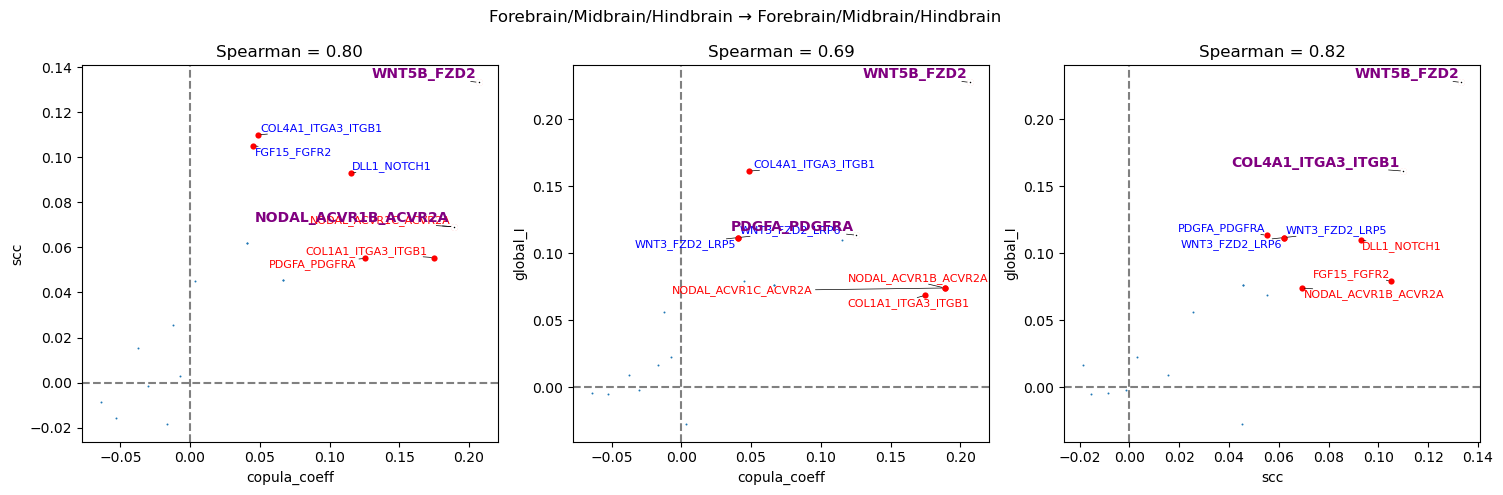

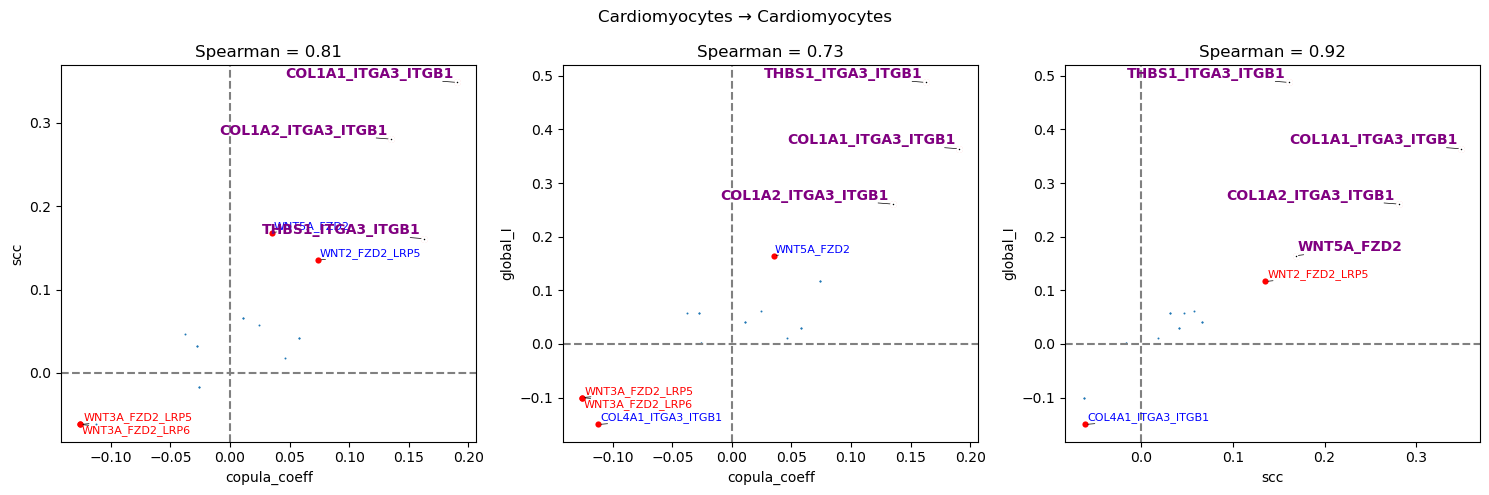

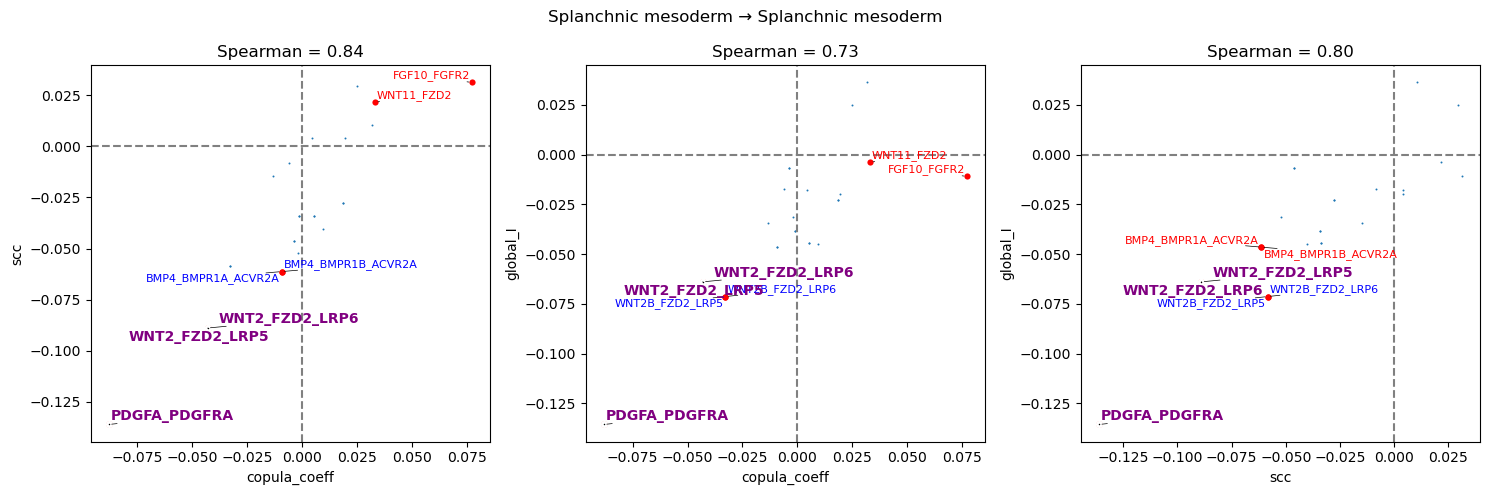

In [113]:
ntop = 5
for gpair in internal_edges:
    res = merged_res[gpair].copy()
    #res = res.drop_duplicates(['ligand', 'receptor'])
    # only take non sparse entries
    
    res = res.loc[res.copula_method == 'copula'].fillna(0)
    res = res.loc[res.index.str.split('_').str[0] != res.index.str.split('_').str[1]]
    if res.shape[0] < 5:
        continue
    ncol = len(score_pair)
    _, ax = plt.subplots(1,ncol, figsize=(5*ncol,5))
    for i,(x_col, y_col) in enumerate(score_pair):
        
        sig1 = res.sort_values(by=x_col, key=lambda x: abs(x), ascending=False)[:ntop]
        sig2 = res.sort_values(by=y_col, key=lambda x: abs(x), ascending=False)[:ntop]

        sig12 = sig1.join(sig2, rsuffix='_2',how='inner')
        
        sns.scatterplot(data = res, 
                        x = x_col, 
                        y = y_col, s = 2, linewidth = 0,ax = ax[i])
        sns.scatterplot(
                data = sig1, 
                x = x_col, 
                y = y_col, 
                s = 20, c='r', linewidth = 0,ax = ax[i])
        sns.scatterplot(
                data = sig2, 
                x = x_col,
                y = y_col, 
                s = 20, c='r', linewidth = 0,ax = ax[i])

        text_sig = []
        for j,r in sig1.drop(sig12.index).iterrows():
            text_sig.append(ax[i].text(x=r[x_col], y = r[y_col], 
                                        s = j,
                                        color=(1, 0, 0),
                                        fontsize = 8
                                    ))
        
        for j,r in sig2.drop(sig12.index).iterrows():
            text_sig.append(ax[i].text(x=r[x_col], y = r[y_col], 
                                        s = j,
                                        color=(0, 0, 1),
                                        fontsize = 8
                                    ))
        
        if(len(text_sig) > 0):
            adjust_text(text_sig,arrowprops=dict(arrowstyle="-", color='black', lw=0.5),ax=ax[i])
        
        if (len(sig12) > 0):
            sns.scatterplot(data = sig12, 
                                x = x_col, y = y_col, s = 10, c='black', linewidth = 2,
                                ax = ax[i])
            text_sig12 = []
            for j,r in sig12.iterrows():
                text_sig12.append(ax[i].text(x=r[x_col], y = r[y_col], 
                                            s = j,
                                            color = (0.5, 0, 0.5),
                                            fontsize = 10,
                                            weight='bold'
                                        ))
            adjust_text(text_sig12,arrowprops=dict(arrowstyle="-", color='black', lw=0.5),ax=ax[i])
        ax[i].set_title(f'Spearman = { stats.spearmanr(res[x_col].values, res[y_col].values)[0] :.2f}')
        ax[i].axhline(0, color='grey', linestyle='--')
        ax[i].axvline(0, color='grey', linestyle='--')
        
    
    plt.suptitle(gpair.replace('=',' → '))
    plt.tight_layout()
    plt.show()

In [116]:
nc_ct = int_edges_subset.loc[
    ((int_edges_subset.celltype1 == 'Neural crest') |
    (int_edges_subset.celltype2 == 'Neural crest'))
].interaction.unique()

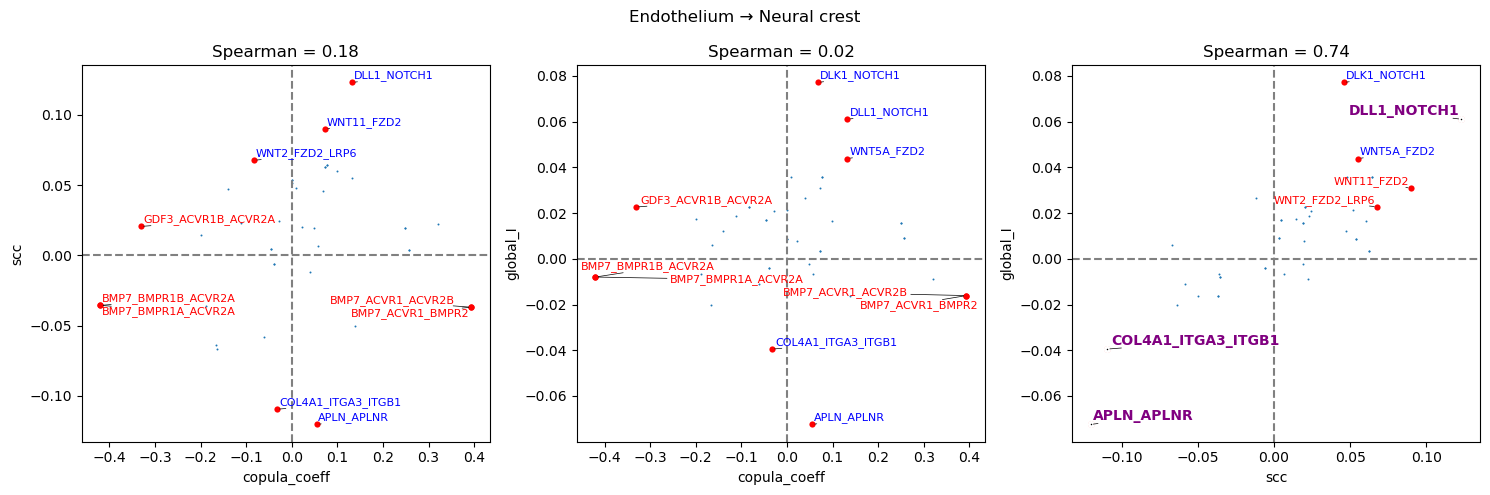

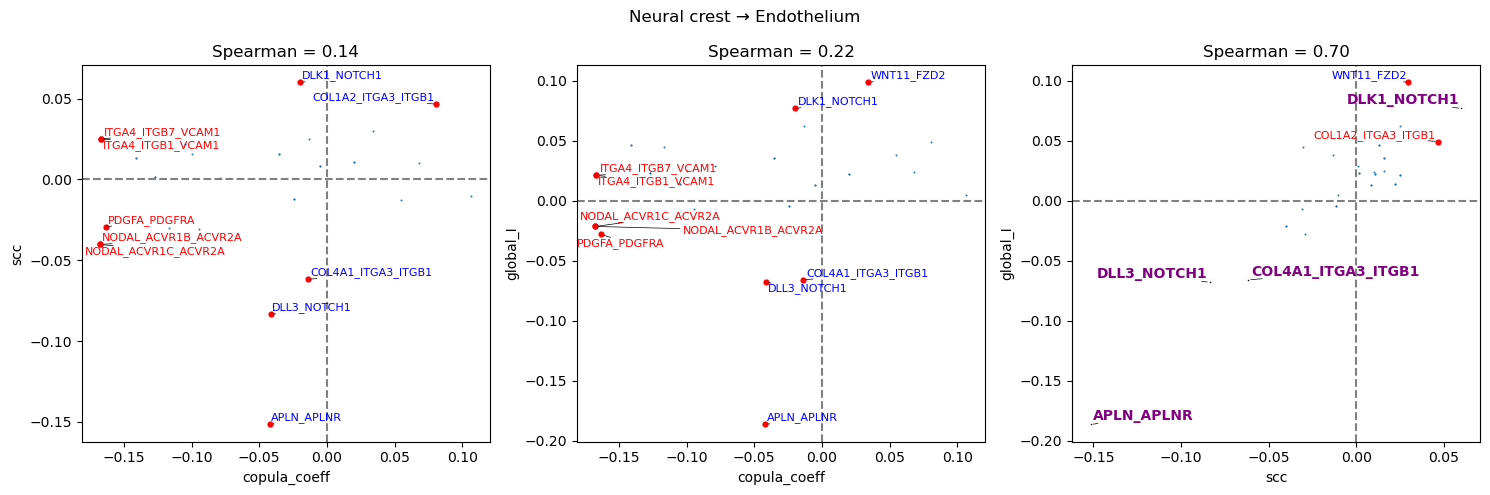

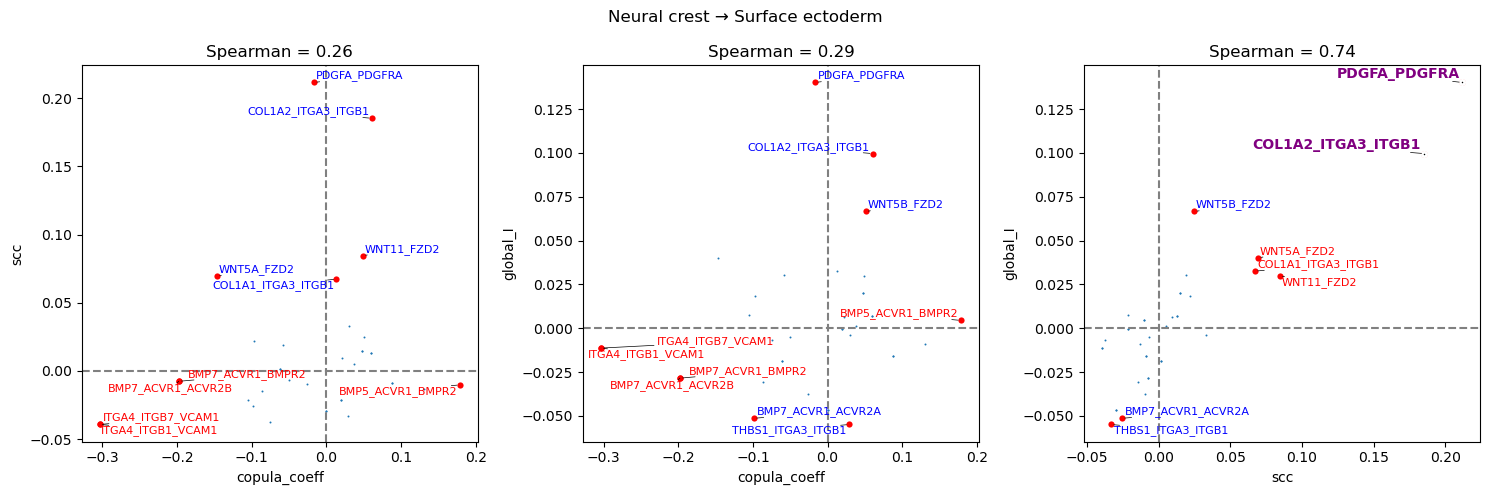

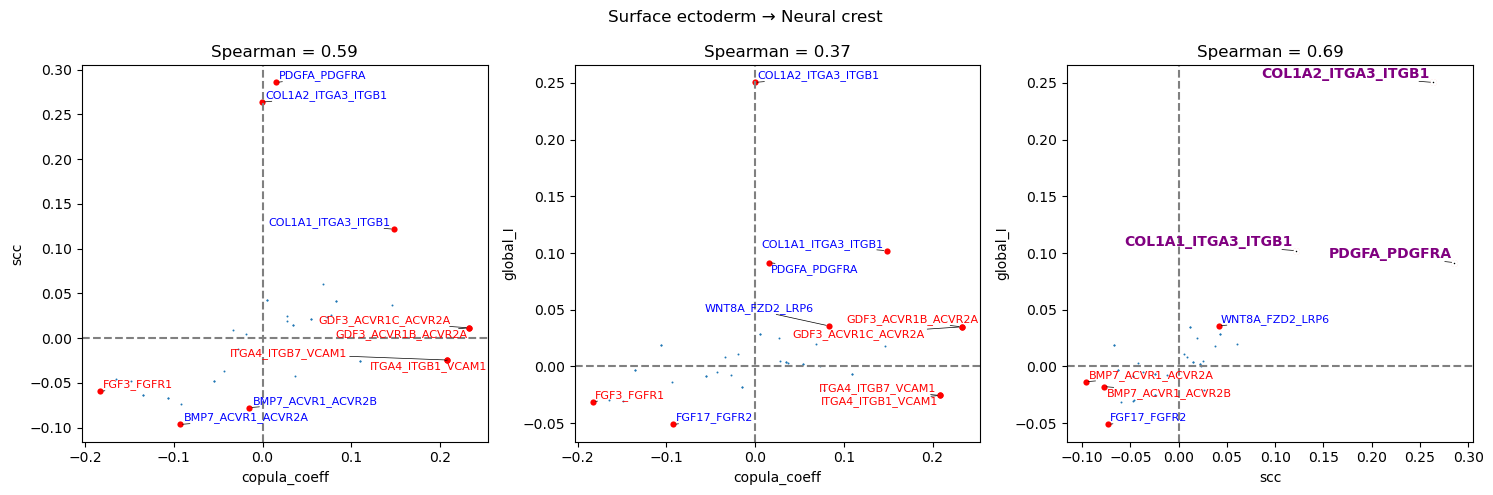

In [117]:
ntop = 5
for gpair in nc_ct:
    res = merged_res[gpair].copy()
    #res = res.drop_duplicates(['ligand', 'receptor'])
    # only take non sparse entries
    
    res = res.loc[res.copula_method == 'copula'].fillna(0)
    res = res.loc[res.index.str.split('_').str[0] != res.index.str.split('_').str[1]]
    if res.shape[0] < 5:
        continue
    ncol = len(score_pair)
    _, ax = plt.subplots(1,ncol, figsize=(5*ncol,5))
    for i,(x_col, y_col) in enumerate(score_pair):
        
        sig1 = res.sort_values(by=x_col, key=lambda x: abs(x), ascending=False)[:ntop]
        sig2 = res.sort_values(by=y_col, key=lambda x: abs(x), ascending=False)[:ntop]

        sig12 = sig1.join(sig2, rsuffix='_2',how='inner')
        
        sns.scatterplot(data = res, 
                        x = x_col, 
                        y = y_col, s = 2, linewidth = 0,ax = ax[i])
        sns.scatterplot(
                data = sig1, 
                x = x_col, 
                y = y_col, 
                s = 20, c='r', linewidth = 0,ax = ax[i])
        sns.scatterplot(
                data = sig2, 
                x = x_col,
                y = y_col, 
                s = 20, c='r', linewidth = 0,ax = ax[i])

        text_sig = []
        for j,r in sig1.drop(sig12.index).iterrows():
            text_sig.append(ax[i].text(x=r[x_col], y = r[y_col], 
                                        s = j,
                                        color=(1, 0, 0),
                                        fontsize = 8
                                    ))
        
        for j,r in sig2.drop(sig12.index).iterrows():
            text_sig.append(ax[i].text(x=r[x_col], y = r[y_col], 
                                        s = j,
                                        color=(0, 0, 1),
                                        fontsize = 8
                                    ))
        
        if(len(text_sig) > 0):
            adjust_text(text_sig,arrowprops=dict(arrowstyle="-", color='black', lw=0.5),ax=ax[i])
        
        if (len(sig12) > 0):
            sns.scatterplot(data = sig12, 
                                x = x_col, y = y_col, s = 10, c='black', linewidth = 2,
                                ax = ax[i])
            text_sig12 = []
            for j,r in sig12.iterrows():
                text_sig12.append(ax[i].text(x=r[x_col], y = r[y_col], 
                                            s = j,
                                            color = (0.5, 0, 0.5),
                                            fontsize = 10,
                                            weight='bold'
                                        ))
            adjust_text(text_sig12,arrowprops=dict(arrowstyle="-", color='black', lw=0.5),ax=ax[i])
        ax[i].set_title(f'Spearman = { stats.spearmanr(res[x_col].values, res[y_col].values)[0] :.2f}')
        ax[i].axhline(0, color='grey', linestyle='--')
        ax[i].axvline(0, color='grey', linestyle='--')
        
    
    plt.suptitle(gpair.replace('=',' → '))
    plt.tight_layout()
    plt.show()